In [24]:
# Implementing Support Vector machines model on dataset for stock price prediction
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import yfinance as yf
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pickle

# Importing the dataset
#initial_df = pd.read_csv('SP500_stock_dataset_PE.csv', delimiter=',')
initial_df = pd.read_csv('SP500_stock_prices.csv', delimiter=',')

# # Create a new column 'Price Movement'
# df['Daily Price Movement'] = np.where(df['Close'] > df['Close'].shift(1), 1, 0)

initial_df.head()

,Date,Ticker,Open,Low,High,Close,Volume,Sector
0,2016-01-04,MMM,148.050003,145.399994,148.320007,146.820007,3277200,Industrials
1,2016-01-05,MMM,146.820007,145.610001,147.500000,147.460007,2688100,Industrials
2,2016-01-06,MMM,145.589996,143.419998,145.759995,144.490005,2997100,Industrials
3,2016-01-07,MMM,142.520004,140.630005,143.130005,140.970001,3553500,Industrials
4,2016-01-08,MMM,141.360001,140.220001,142.500000,140.490005,2664000,Industrials


In [25]:
# Make date column the index
initial_df = initial_df.set_index('Date')

In [26]:
# only display year, month and day in index
initial_df.index = pd.to_datetime(initial_df.index).date
initial_df_test = initial_df.copy()
data = initial_df
data
# make return column
data['Return'] = data['Close'].pct_change()

In [27]:
print(data['Sector'].unique())
# assign each different Sector string its own number
data['Sector'] = data['Sector'].map({'Consumer Discretionary': 0, 'Consumer Staples': 1, 'Energy': 2, 'Financials': 3, 'Health Care': 4, 'Industrials': 5, 'Information Technology': 6, 'Materials': 7, 'Real Estate': 8, 'Communication Services': 9, 'Utilities': 10})

['Industrials' 'Health Care' 'Information Technology'
 'Communication Services' 'Consumer Staples' 'Consumer Discretionary'
 'Utilities' 'Financials' 'Materials' 'Real Estate' 'Energy']


In [28]:
# make a new column for whether or not the price has increased or decreased from the previous 62 days
# 1 = increased, 0 = decreased, doing so by comparing openprice of today with openprice of 62 days ago
data['63-day Price Movement'] = np.where(data['Close'] > data['Close'].shift(-63), 1, 0)

In [29]:
# Make the tickers to categoricals, but keep the original order of the tickers
data['Ticker'] = pd.Categorical(data['Ticker'], categories=data['Ticker'].unique(), ordered=True)
data['Ticker'] = data['Ticker'].cat.codes
# # make target column
# data['Target'] = data['62-day Price Movement'].shift(-62)
# #data['Price Movement 62 Days'] = data['Price Movement'].shift(62)
data.dropna(inplace=True)
data

,Ticker,Open,Low,High,Close,Volume,Sector,Return,63-day Price Movement
2016-01-05,0,146.820007,145.610001,147.500000,147.460007,2688100,5,0.004359,0
2016-01-06,0,145.589996,143.419998,145.759995,144.490005,2997100,5,-0.020141,0
2016-01-07,0,142.520004,140.630005,143.130005,140.970001,3553500,5,-0.024362,0
2016-01-08,0,141.360001,140.220001,142.500000,140.490005,2664000,5,-0.003405,0
2016-01-11,0,140.970001,139.410004,141.429993,140.460007,2775500,5,-0.000214,0
...,...,...,...,...,...,...,...,...,...
2020-03-26,496,109.510002,109.510002,118.690002,117.910004,4159000,4,0.089641,0
2020-03-27,496,114.519997,111.040001,117.779999,111.769997,2870100,4,-0.052074,0
2020-03-30,496,113.629997,112.430000,117.750000,116.680000,2031900,4,0.043930,0
2020-03-31,496,115.680000,113.900002,120.250000,117.690002,3956000,4,0.008656,0


In [30]:
# select only the ticker index
indiviual_datas = []

for ticker in data['Ticker'].unique():
    #data_ticker = data.xs(0, level=1).copy()
    data_ticker = data[data['Ticker'] == ticker].copy()
    # make target column
    data_ticker['Target'] = data_ticker['63-day Price Movement'].shift(-63)
    #data['Price Movement 62 Days'] = data['Price Movement'].shift(62)
    data_ticker.dropna(inplace=True)
    data_ticker

    indiviual_datas.append(data_ticker)

data_all_tickers = pd.concat(indiviual_datas)

data_all_tickers

,Ticker,Open,Low,High,Close,Volume,Sector,Return,63-day Price Movement,Target
2016-01-05,0,146.820007,145.610001,147.500000,147.460007,2688100,5,0.004359,0,0.0
2016-01-06,0,145.589996,143.419998,145.759995,144.490005,2997100,5,-0.020141,0,0.0
2016-01-07,0,142.520004,140.630005,143.130005,140.970001,3553500,5,-0.024362,0,0.0
2016-01-08,0,141.360001,140.220001,142.500000,140.490005,2664000,5,-0.003405,0,0.0
2016-01-11,0,140.970001,139.410004,141.429993,140.460007,2775500,5,-0.000214,0,0.0
...,...,...,...,...,...,...,...,...,...,...
2019-12-24,496,132.210007,131.289993,133.080002,132.919998,442500,4,0.004155,1,0.0
2019-12-26,496,133.190002,132.320007,133.190002,133.029999,929400,4,0.000828,1,0.0
2019-12-27,496,133.399994,132.380005,133.479996,133.250000,1296100,4,0.001654,1,0.0
2019-12-30,496,133.570007,131.809998,133.660004,132.210007,942000,4,-0.007805,1,0.0


In [31]:
#check PE-Ratio for inf values
# find Tickers with inf values for PE-Ratio
data_all_tickers[data_all_tickers['PE-Ratio'] == np.inf]['Ticker'].unique()
# removing all rows with the tickers that have infinity values in their PE-Ratios
for wrong_ticker in data_all_tickers[data_all_tickers['PE-Ratio'] == np.inf]['Ticker'].unique():
    data_all_tickers = data_all_tickers[data_all_tickers['Ticker'] != wrong_ticker]


KeyError: 'PE-Ratio'

In [33]:
# Splitting the dataset into the Training set and Test set according to date
# Define the specific date to split the DataFrame
# Create an offset of 62 Business days
# bd = pd.tseries.offsets.BusinessDay(n = 63)
# split_date = pd.to_datetime('2019-09-30') - bd

# # set a start date for the training set to be 62 days after the first date in the dataset
# start_date = pd.to_datetime('2016-01-04') + bd

# small test dataset creation:

bd = pd.tseries.offsets.BusinessDay(n = 63)
split_date = pd.to_datetime('2019-12-27') - bd
start_date = pd.to_datetime('2017-09-30') + bd


# Split the DataFrame into training and test sets based on the specific date
# for train we want all the data from the start date to the split date, this ensures that we have 63 days of data for each stock
# for test we want all the data from the split date to the end of the dataset
train = data_all_tickers.loc[(start_date < data_all_tickers.index) & (data_all_tickers.index < split_date)]
train_log = train
train_log['Low'] = np.log(train_log['Low'])
train_log['High'] = np.log(train_log['High'])
train_log['Open'] = np.log(train_log['Open'])
train_log['Close'] = np.log(train_log['Close'])
train_log['Volume'] = np.log(train_log['Volume']).apply(lambda x: np.log(x) if x > 0 else 0)
#train_log['PE-Ratio'] = train_log(['PE-Ratio'])
#train_log['Volume'] = np.log(train_log['Volume'])
test = data_all_tickers.loc[data_all_tickers.index >= split_date]
test_log = test
test_log['Low'] = np.log(test_log['Low'])
test_log['High'] = np.log(test_log['High'])
test_log['Open'] = np.log(test_log['Open'])
test_log['Close'] = np.log(test_log['Close'])
test_log['Volume'] = np.log(test_log['Volume']).apply(lambda x: np.log(x) if x > 0 else 0)
#test_log['PE-Ratio'] = test_log(['PE-Ratio'])
#X_train = train_log[['Ticker','Close', 'Volume', 'Sector']]
X_train = train_log[['Ticker','Open', 'Low', 'High','Close', 'Volume', 'Sector']]
y_train = train['Target']
X_test = test_log[['Ticker', 'Open', 'Low', 'High','Close', 'Volume', 'Sector']]
#X_test = test_log[['Ticker', 'Close', 'Volume', 'Sector']]
y_test = test['Target']


C:\Users\nicol\AppData\Local\Temp\ipykernel_28524\2914851747.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicol\AppData\Local\Temp\ipykernel_28524\2914851747.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicol\AppData\Local\Temp\ipykernel_28524\2914851747.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

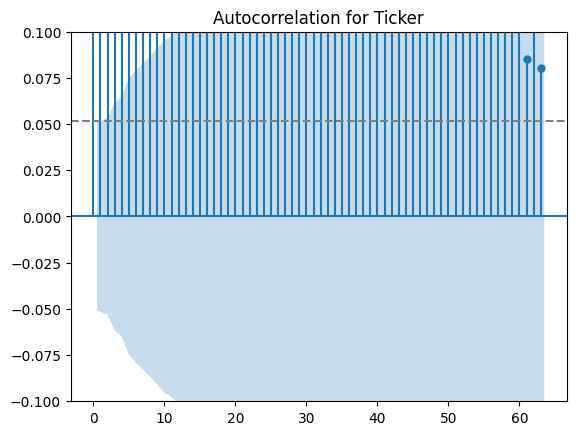

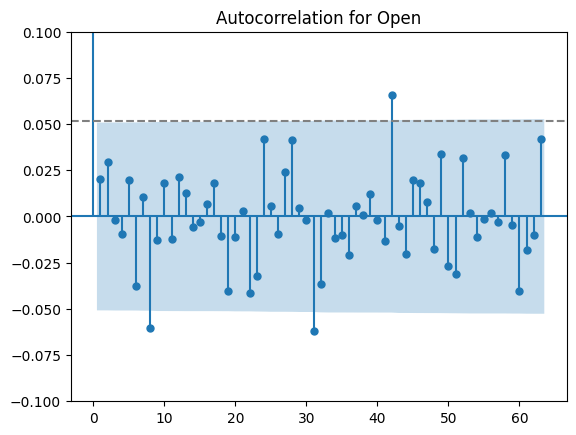

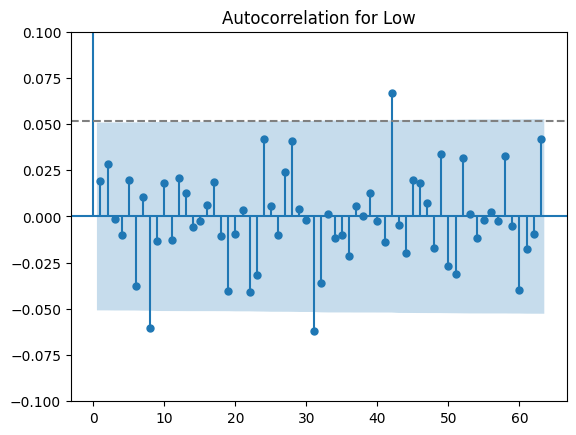

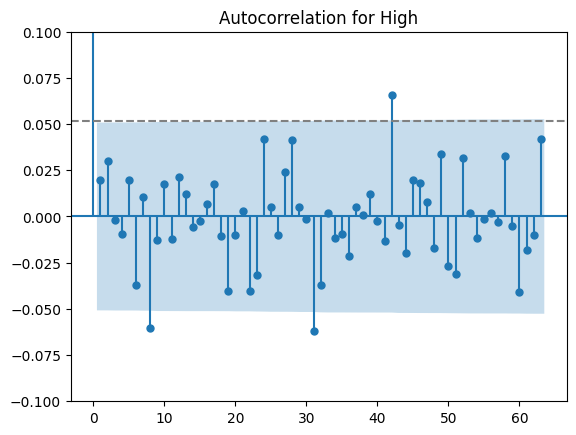

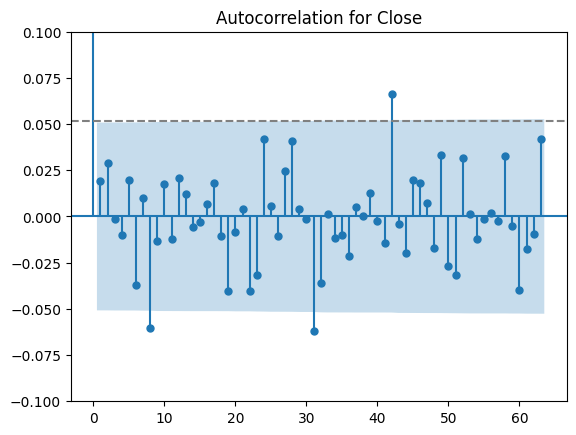

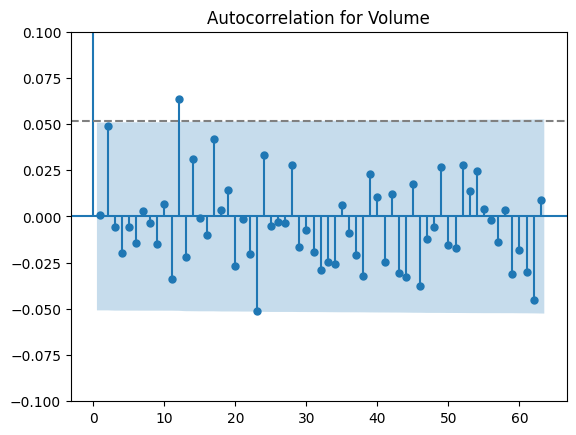

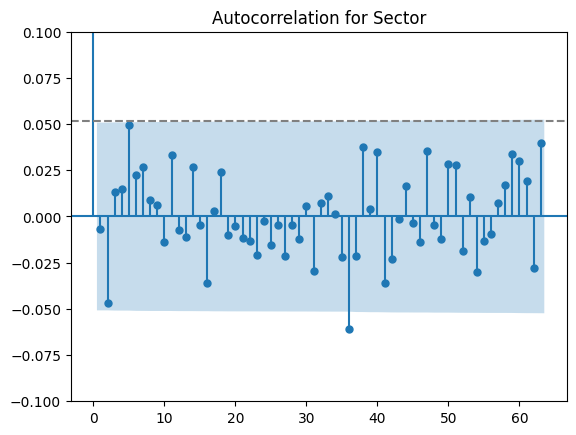

In [43]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Make sure your data is sorted by date
X_train = X_train.sort_index()

# Remove non-numeric features for this analysis
numeric_features = X_train.select_dtypes(include=[np.number])

for feature in numeric_features.columns:
    sm.graphics.tsa.plot_acf(X_train[feature].values.squeeze(), lags=63)
    # check if the autocorrelation is significant
    plt.axhline(y=2/np.sqrt(len(X_train[feature])),linestyle='--',color='gray')
    # zoom in on the y axis
    plt.ylim(-0.1,0.1)
    plt.title('Autocorrelation for ' + feature)
    plt.show()

In [34]:
# print any nan values in the test set
print(test.isnull().sum())


Ticker                   0
Open                     0
Low                      0
High                     0
Close                    0
Volume                   0
Sector                   0
Return                   0
63-day Price Movement    0
Target                   0
dtype: int64


In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVM model
model = SVC(kernel='rbf',probability=True) # linear, rbf, poly, sigmoid
model.fit(X_train, y_train)


SVC(probability=True)

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# shuffle the data, but ensure that the X and y data are shuffled in the same way.
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=69)
X_train_shuffled = pd.DataFrame(X_train_shuffled, columns=['Ticker', 'Open', 'Low', 'High', 'Close', 'Volume', 'Sector', 'PE-Ratio'])
# Convert categorical variables to dummy variables with custom names
#X_train_shuffled = pd.get_dummies(X_train_shuffled, columns=['Ticker', 'Sector'], prefix=['Ticker', 'Sector'], prefix_sep='_')
# Convert categorical variables to dummy variables
# Convert categorical variables to dummy variables
X_train_shuffled = pd.get_dummies(X_train_shuffled, columns=['Ticker', 'Sector'])

# Rename the dummy variable columns with sequential numbering
ticker_count = 0
sector_count = 0

for column in X_train_shuffled.columns:
    if column.startswith('Ticker_'):
        new_column_name = f'Ticker_{ticker_count}'
        X_train_shuffled.rename(columns={column: new_column_name}, inplace=True)
        ticker_count += 1
    elif column.startswith('Sector_'):
        new_column_name = f'Sector_{sector_count}'
        X_train_shuffled.rename(columns={column: new_column_name}, inplace=True)
        sector_count += 1


# Split the data into training and testing sets
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_train_shuffled, y_train_shuffled, test_size=0.2, random_state=42)

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train_RF, y_train_RF)

# Make predictions on the test set
y_pred = rf.predict(X_test_RF)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_RF, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.3486153027888655


In [16]:
# Get feature importances
importances = rf.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({"feature": X_train_RF.columns, "importance": importances})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values("importance", ascending=False)

# Print the feature importances
print(feature_importances[0:20])

        feature  importance
5      PE-Ratio    0.226339
4        Volume    0.135809
2          High    0.109495
0          Open    0.108610
1           Low    0.100372
3         Close    0.098004
489    Sector_2    0.012001
490    Sector_3    0.004838
492    Sector_5    0.004407
493    Sector_6    0.004379
491    Sector_4    0.004363
487    Sector_0    0.004345
494    Sector_7    0.003564
488    Sector_1    0.003311
495    Sector_8    0.002894
497   Sector_10    0.002655
407  Ticker_401    0.002384
496    Sector_9    0.002110
53    Ticker_47    0.001898
161  Ticker_155    0.001748


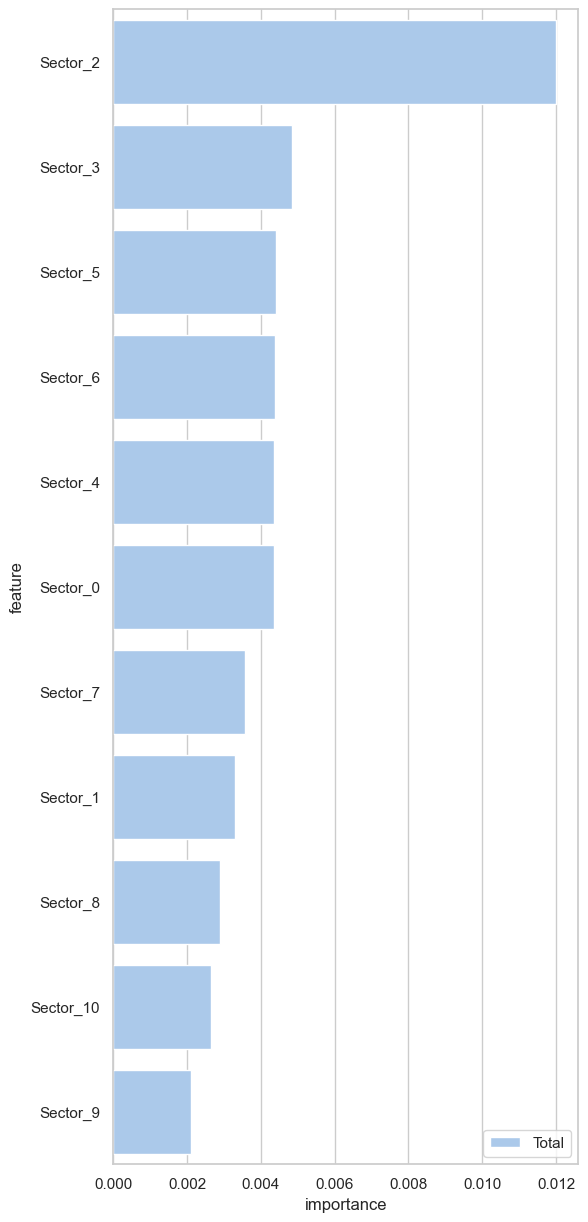

In [17]:
# Make a plot about the feature importance of the different sector dummy variables in the model
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Initialize a matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))
# only look at the sector dummy variables
feature_importances = feature_importances[feature_importances['feature'].str.startswith('Sector_')]
# Plot their importance
sns.set_color_codes("pastel")
sns.barplot(x="importance", y="feature", data=feature_importances,
            label="Total", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)


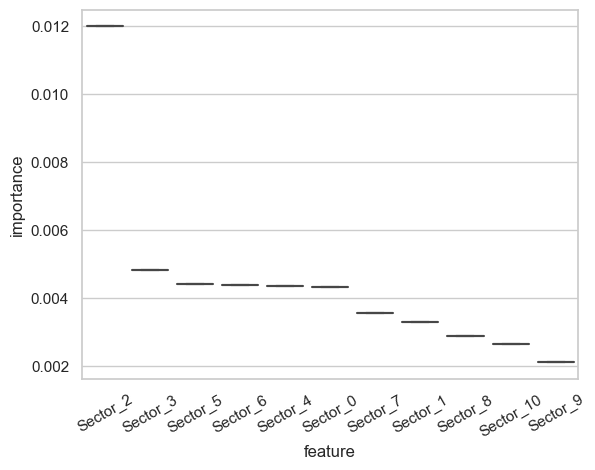

In [18]:
# make a boxplot of the sector dummy variables
sns.boxplot(x="feature", y="importance", data=feature_importances)
# rotate the x-axis labels
plt.xticks(rotation=30)
plt.show()

['Industrials' 'Health Care' 'Information Technology'
 'Communication Services' 'Consumer Staples' 'Consumer Discretionary'
 'Utilities' 'Financials' 'Materials' 'Real Estate' 'Energy']

In [17]:
X_train = train_log[['Ticker','Open', 'Low', 'High','Close', 'Volume', 'Sector']]
y_train = train['Target']
X_test = test_log[['Ticker', 'Open', 'Low', 'High','Close', 'Volume', 'Sector']]
y_test = test['Target']

gammas = ['scale',0.1, 1, 10, 100]
for gamma in gammas:
    svc = SVC(kernel='rbf', gamma=gamma).fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    print("Gamma =", gamma, "Accuracy =", accuracy_score(y_test, y_pred))


Gamma = scale Accuracy = 0.37770917338709675
Gamma = 0.1 Accuracy = 0.3475617439516129
Gamma = 1 Accuracy = 0.4148500504032258
Gamma = 10 Accuracy = 0.4653162802419355
Gamma = 100 Accuracy = 0.46361517137096775


In [18]:
X_train = train_log[['Ticker','Open', 'Low', 'High','Close', 'Volume', 'Sector']]
y_train = train['Target']
X_test = test_log[['Ticker', 'Open', 'Low', 'High','Close', 'Volume', 'Sector']]
y_test = test['Target']

cs = [0.1, 1, 10, 100]
for c in cs:
   
   svc = SVC(kernel='rbf', C=c).fit(X_train, y_train) 
   y_pred = svc.predict(X_test)
   print("C =", c, "Accuracy =", accuracy_score(y_test, y_pred))

C = 0.1 Accuracy = 0.37770917338709675
C = 1 Accuracy = 0.37770917338709675
C = 10 Accuracy = 0.37770917338709675
C = 100 Accuracy = 0.37770917338709675


In [36]:
# get probabilities for each class (training set)
y_pred_proba_train = model.predict_proba(X_train)
y_scores_train = y_pred_proba_train[:, 1]

In [37]:

# Get the probabilities for each class
y_pred_proba_test = model.predict_proba(X_test)

In [38]:
# predicted probabilities for the positive class
#y_scores = model.predict_proba(X_test)[:, 1]
y_scores_test = y_pred_proba_test[:, 1]

In [39]:
y_pred_proba_train

array([[0.61015709, 0.38984291],
       [0.61008256, 0.38991744],
       [0.61035509, 0.38964491],
       ...,
       [0.60864861, 0.39135139],
       [0.60947883, 0.39052117],
       [0.60888606, 0.39111394]])

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



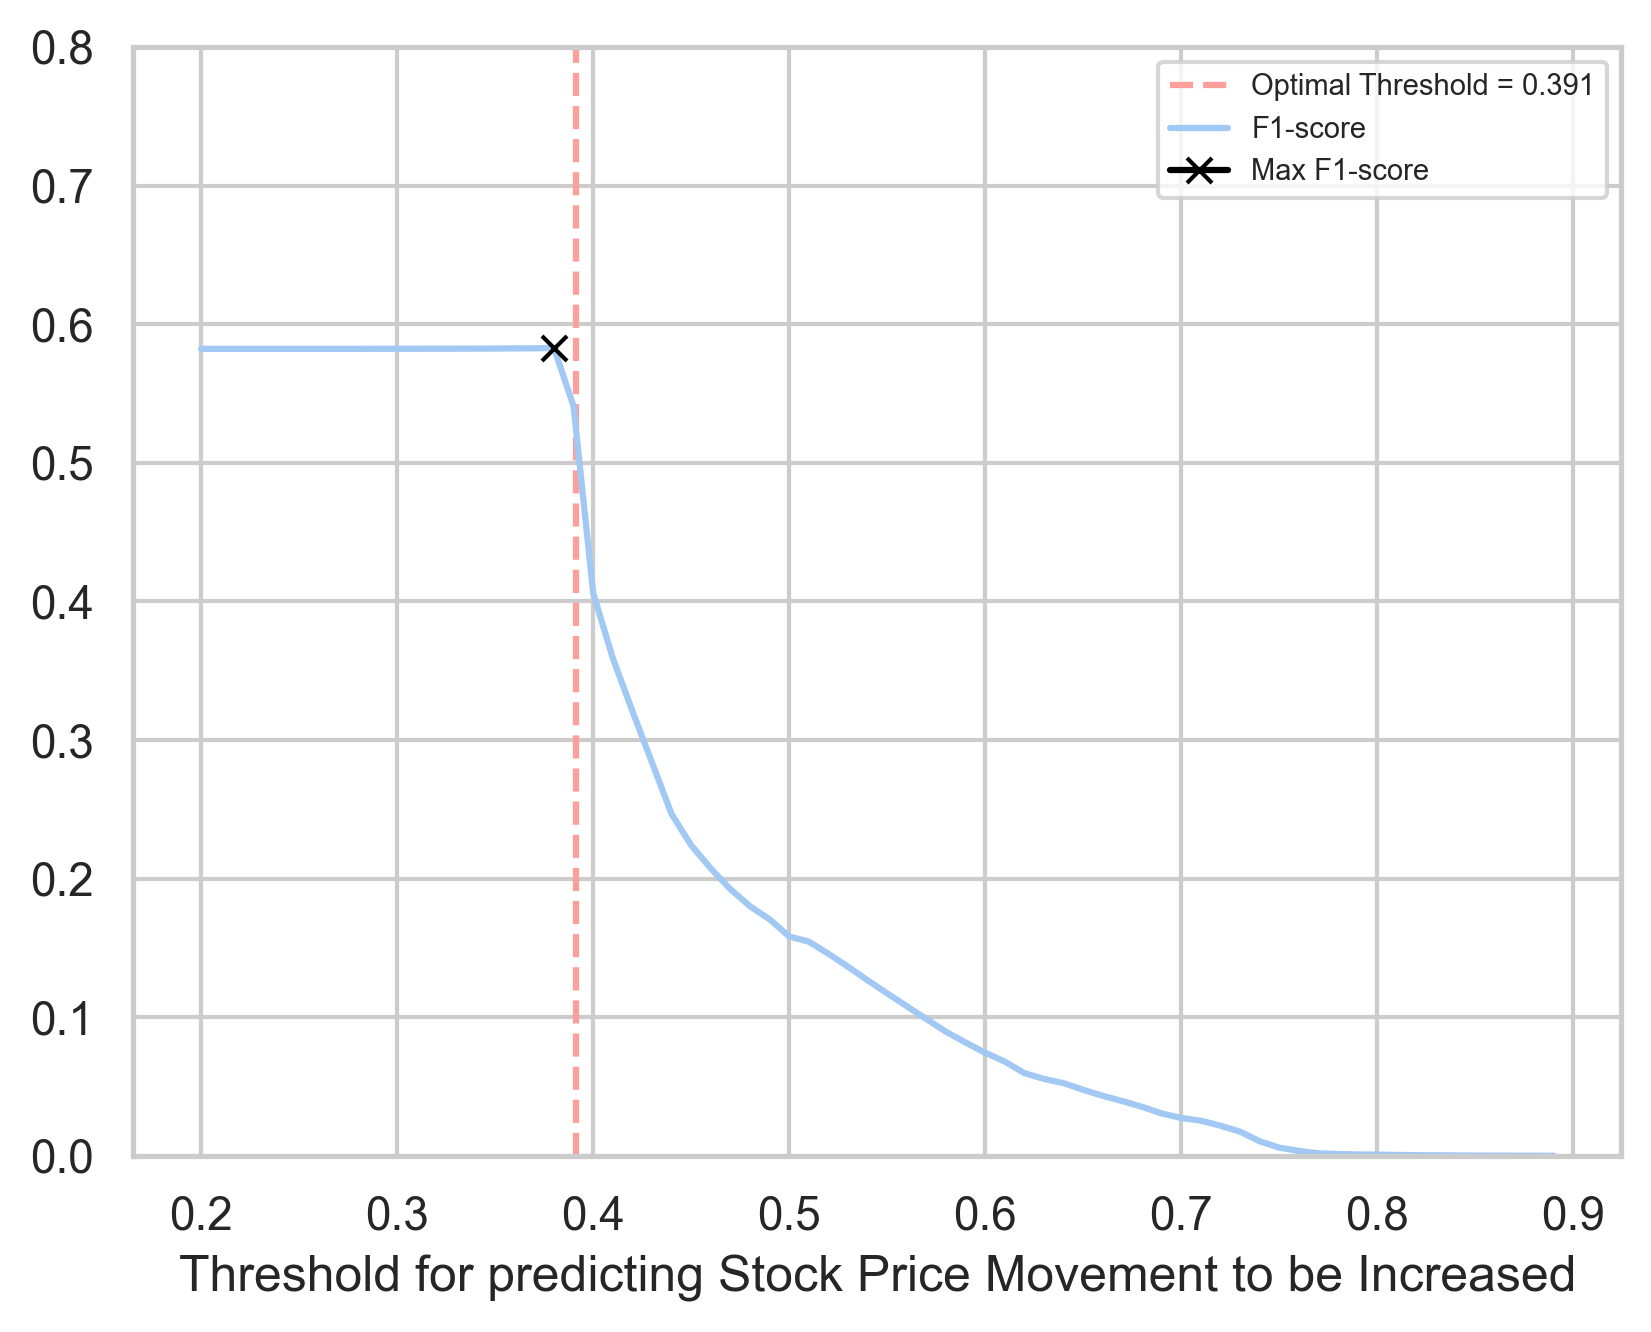

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

precision = []
recall = []
f1 = []
thresholds = np.arange(0.2, 0.9, 0.01)
for threshold in thresholds:
    y_pred = (y_scores_train > threshold).astype(int)
    precision.append(precision_score(y_train, y_pred))
    recall.append(recall_score(y_train, y_pred))
    f1.append(f1_score(y_train, y_pred))
    
# Create a new figure with a dpi of 300
plt.figure(dpi=300)
# make line at threshold 0.3859
plt.plot([0.391, 0.391], [0, 0.8], linestyle='--', label='Optimal Threshold = 0.391', color='r')
plt.plot(thresholds, f1, label='F1-score',color='b')
plt.xlabel('Threshold for predicting Stock Price Movement to be Increased')
# plot the point for the highest F1 score
plt.plot(thresholds[np.argmax(f1)], np.max(f1), marker='x', color='black', label='Max F1-score')
plt.ylim([0, 0.8])
plt.legend(loc='upper right', fontsize=7)
plt.show()


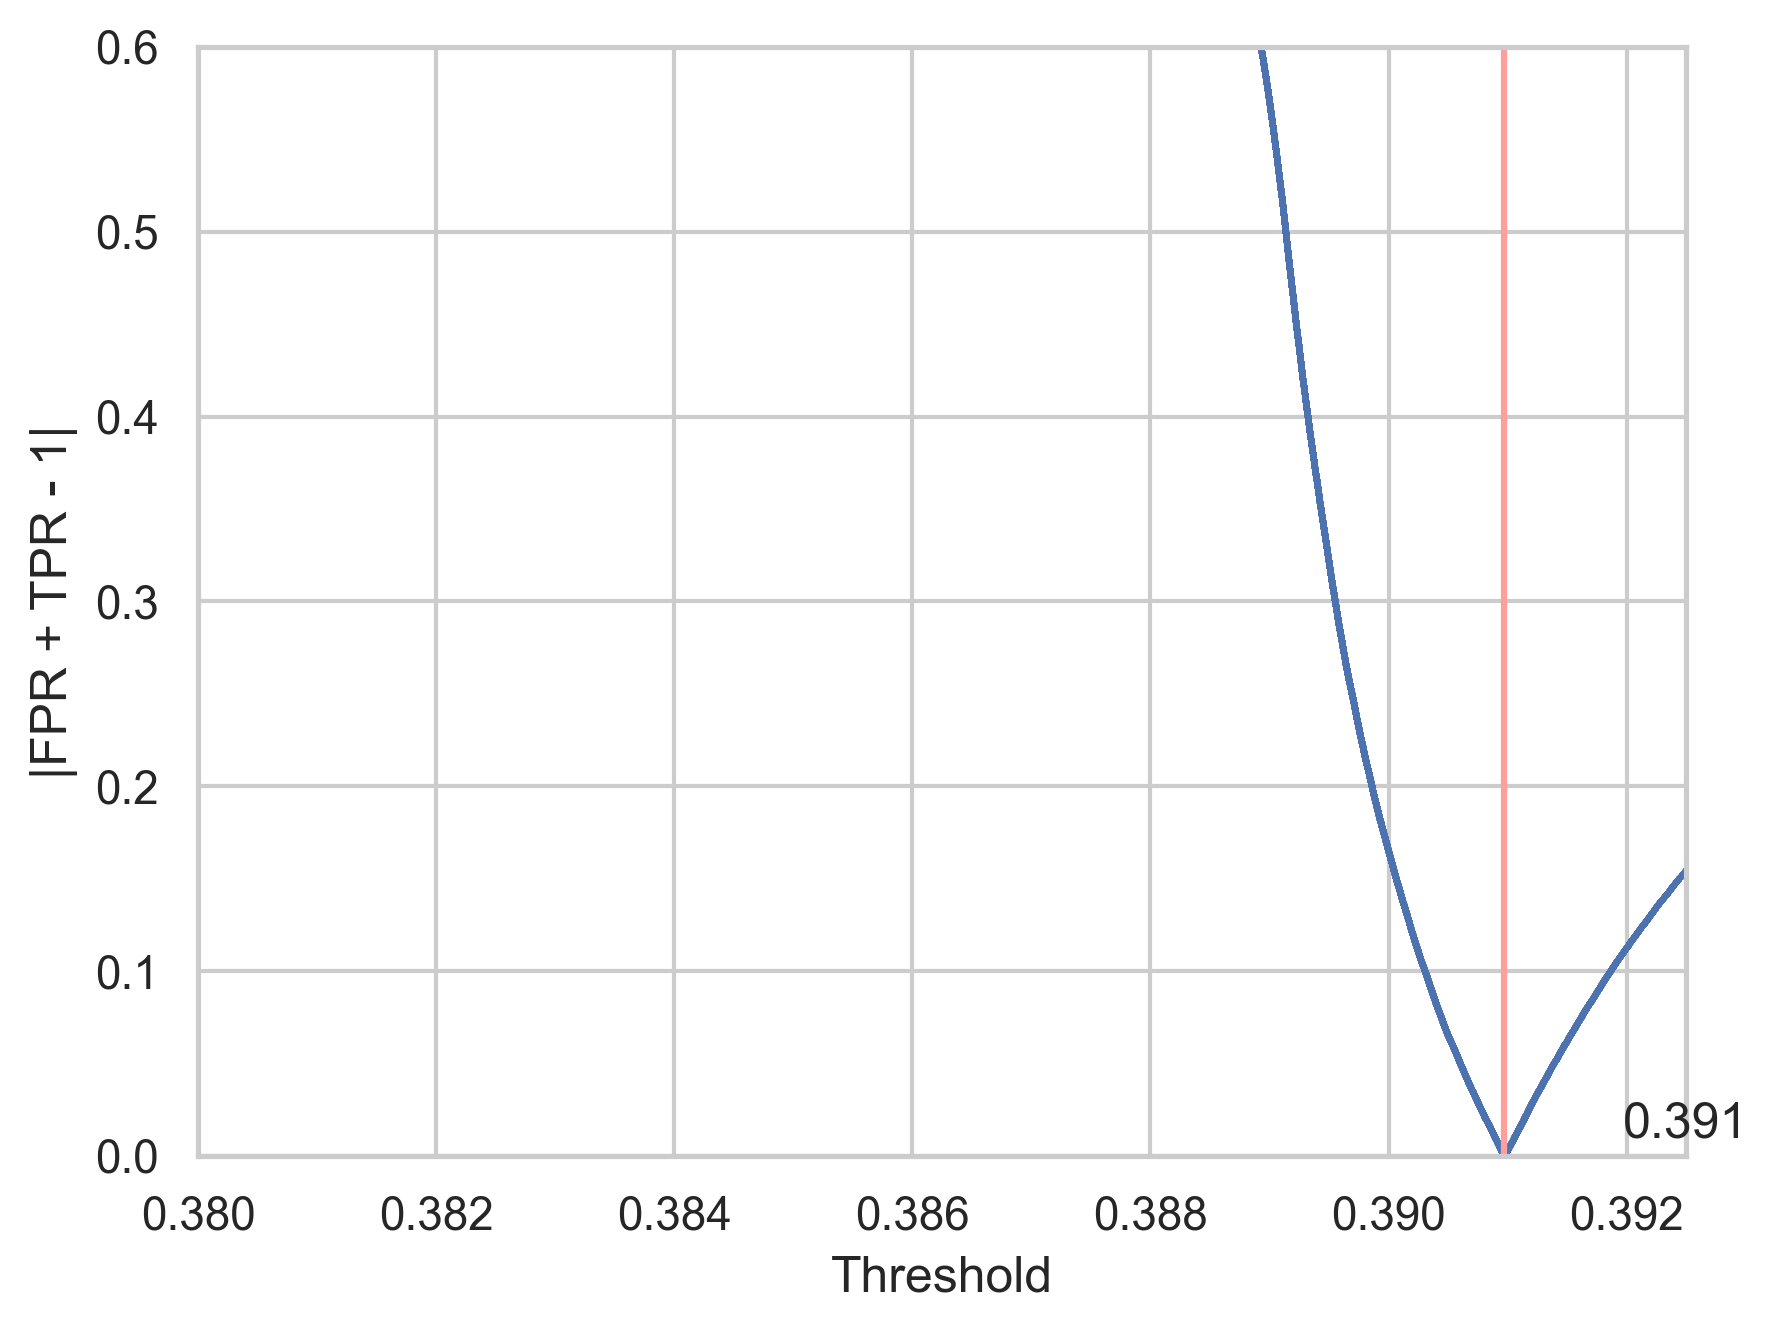

In [42]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores_train, drop_intermediate=False)

# Create a new figure with a dpi of 300
plt.figure(dpi=300)

plt.scatter(thresholds, np.abs(fpr + tpr - 1), s=0.1)
plt.xlabel("Threshold")

# let x-axis go from 0.384 to 0.3925
plt.xlim([0,1])
plt.ylabel("|FPR + TPR - 1|")

# plot the vertical line at the best threshold for FPR + TPR - 1
plt.axvline(x=thresholds[np.argmin(np.abs(fpr + tpr - 1))], color='r')

# plot the exact threshold value for FPR + TPR - 1
plt.text(thresholds[np.argmin(np.abs(fpr + tpr - 1))] + 0.001, 0.01, str(round(thresholds[np.argmin(np.abs(fpr + tpr - 1))], 4)))
plt.ylim([0,0.6])
plt.xlim([0.380,0.3925])
plt.show()


In [44]:
from sklearn.metrics import f1_score
# Create a list of possible thresholds and f1 scores
thresholds = np.arange(0.391, 0.5, 0.001)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_scores_train > threshold).astype(int)
    score = f1_score(y_train, y_pred)
    f1_scores.append(score)

# Find the threshold that gave the highest f1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
optimal_score = np.max(f1_scores)

print(f"Optimal threshold is: {optimal_threshold}")
print(f"Highest F1 score at optimal threshold is: {optimal_score}")



Optimal threshold is: 0.391
Highest F1 score at optimal threshold is: 0.5167764866852871


In [45]:
# Set custom threshold
threshold = optimal_threshold

# Make a prediction using the trained SVM model with the custom threshold applied
y_pred = (y_pred_proba_test[:,1] > threshold).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4017045454545455


In [46]:
print(sum(y_pred))

15557


In [47]:
print(len(y_pred))

31680


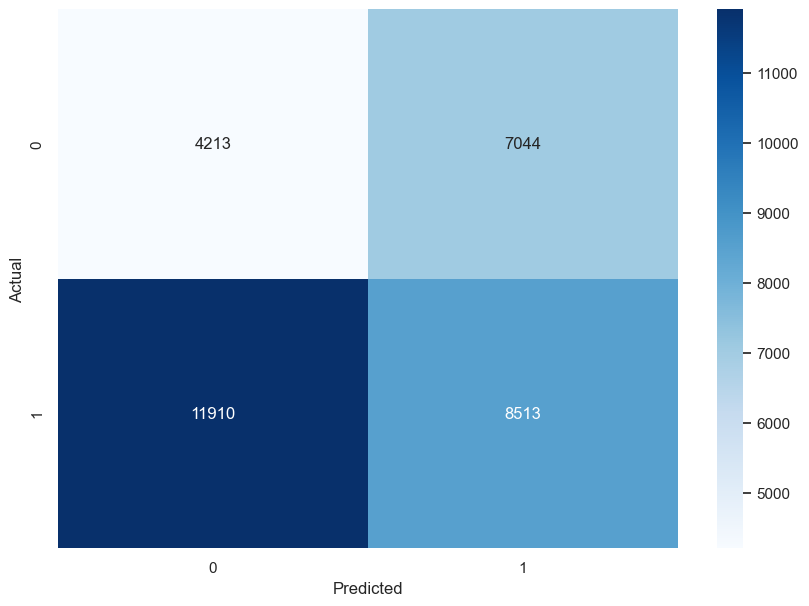

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap()
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [29]:
# save model to file
# import pickle
# pickle.dump(model, open('svm_modelwithoutPE.sav', 'wb'))

In [49]:
ticker_name_df = pd.read_csv('SP500_stock_prices.csv', delimiter=',')
# Make date column the index
ticker_name_df = ticker_name_df.set_index('Date')
# only display year, month and day in index
ticker_name_df.index = pd.to_datetime(ticker_name_df.index).date
# only keep the Ticker
ticker_name_df = ticker_name_df[['Ticker']]
# drop duplicates
ticker_name_df = ticker_name_df.drop_duplicates()
# remove the index
ticker_name_df = ticker_name_df.reset_index(drop=True)
ticker_name_df

,Ticker
0,MMM
1,AOS
2,ABT
3,ABBV
4,ACN
...,...
492,YUM
493,ZBRA
494,ZBH
495,ZION


In [50]:
test['Ticker'] = test['Ticker'].astype('category')
#  make y_pred and y_pred_proba a column in the test dataset
test['Prediction'] = y_pred
test['Prediction Probability (0)'] = y_pred_proba_test[:,0]
test['Prediction Probability (1)'] = y_pred_proba_test[:,1]
# only keep columns for ticker, target, and prediction
test = test[['Ticker', 'Target', 'Prediction', 'Prediction Probability (1)', 'Prediction Probability (0)', 'Return']]
# make the ticker column a name again


C:\Users\nicol\AppData\Local\Temp\ipykernel_28524\2504989947.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicol\AppData\Local\Temp\ipykernel_28524\2504989947.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicol\AppData\Local\Temp\ipykernel_28524\2504989947.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

__Portfolio Performance, if bought on each testing day and kept for respective 62 trade days.__

In [51]:
import cvxpy as cp
import pandas as pd

def calculate_optimal_weights(test, date):
    # only keep the rows of a specific date
    # make a date be of type datetime
    date = pd.to_datetime(date)
    
    # make a new dataframe where return is the index and each column is a ticker
    return_df = test.pivot(columns='Ticker', values='Return')
    # remove stocks that have nan values in the return column
    return_df = return_df.dropna(axis=1)
    # for each ticker only keep the row of the input date
    test = test.groupby('Ticker').apply(lambda x: x.loc[x.index == date])
    test['Ticker'] = test['Ticker'].cat.remove_unused_categories()
    
    # ensure that the tickers in test are the same as the tickers in return_df
    test = test[test['Ticker'].isin(return_df.columns)]

    return_deviation = return_df.iloc[0:62]
    
    # Calculate the covariance matrix
    cov_matrix = return_deviation.cov()
    # Force the covariance matrix to be symmetric
    cov_matrix = (cov_matrix + cov_matrix.T) / 2
    
    # Number of stocks
    n = len(test['Ticker'])
    # Weights for each stock in the portfolio
    w = cp.Variable(n)
    # Objective is to minimize portfolio variance
    risk = cp.quad_form(w, cov_matrix)
    
    
    objective = cp.Minimize(risk)
   # Get the number of stocks
    n_stocks = len(test["Prediction"])

    # Get the indices of the 10 tickers with the highest predicted probabilities
    top_10_indices = test["Prediction"].nlargest(10).index

    # Constraints:
    # - weights must sum to 1
    # - only consider stocks where the SVM prediction is 1 (price will increase)
    # - expected portfolio return must be at least a certain value (e.g., 0.01)
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w[test["Prediction"] == 0] == 0,
    ]

    # Only keep the 10 stocks with the highest prediction probability of increasing in price
    # Set weights for non-top 10 tickers to zero
    constraints.extend([w[i] == 0 for i in range(n_stocks) if i not in top_10_indices])

    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()



    # Get the optimal weights
    optimal_weights = w.value
    if optimal_weights is None:
        optimal_weights = np.zeros(n)
    # Create a dataframe with the optimal weights
    optimal_weights_df = pd.DataFrame(optimal_weights, index=test["Ticker"])
    # add the ticker names to the dataframe
    optimal_weights_df = optimal_weights_df.join(ticker_name_df)
    # remove the index
    optimal_weights_df = optimal_weights_df.reset_index(drop=True)
    # make the ticker the index
    optimal_weights_df = optimal_weights_df.set_index('Ticker')
    # make the column name weights
    optimal_weights_df.columns = ['Weights']

    # Sort the dataframe by the optimal weights
    optimal_weights_df = optimal_weights_df.sort_values(by=['Weights'], ascending=False)

    # Only keep the top 10 stocks and their weights, but exclude the most weighted stock
    #optimal_weights_df = optimal_weights_df.iloc[1:11]
    optimal_weights_df = optimal_weights_df.head(10)
    # normalize the weights so that they sum to 1
    optimal_weights_df['Weights'] = optimal_weights_df['Weights'] / optimal_weights_df['Weights'].sum()
    return round(optimal_weights_df,3)


In [52]:

import pandas as pd

def calculate_return(ticker, df, start_date):
    # Convert string dates to datetime
    start_date = pd.to_datetime(start_date)
    # Calculate the end date as start date + 62 trading days
    end_date = start_date + pd.tseries.offsets.BDay(63)
    # remove nan values from df
    df = df.dropna(axis=1)
    
    # Filter the dataframe for the given ticker
    df_ticker = df[df['Ticker'] == ticker]
    # Filter data between start and end dates
    mask = (df_ticker.index >= start_date) & (df_ticker.index <= end_date)
    df_ticker = df_ticker.loc[mask]
    
    # Get the opening price at the start and end dates
    start_price = df_ticker['Open'].iloc[0]
    end_price = df_ticker['Open'].iloc[-1]

    # Calculate the return
    return_percent = ((end_price - start_price) / start_price) * 100

    return round(return_percent,2)


In [53]:
def calculate_average_return(test, initial_df, prob_threshold):
    # Initialize returns list
    returns_list = []

    # For each date in the test set
    for date in test.index.unique():
        # Calculate the optimal weights for the portfolio
        optimal_weights_df = calculate_optimal_weights(test, date, prob_threshold)

        # Calculate the return of the portfolio
        return_list = []
        for ticker in optimal_weights_df.index:
            if optimal_weights_df.loc[ticker]['Weights'] > 0:
                # Calculate the return of the stock
                return_list.append(calculate_return(ticker, initial_df, date))

        # Calculate the return of the portfolio
        portfolio_return = 0
        for i in range(len(return_list)):
            portfolio_return += return_list[i] * optimal_weights_df.iloc[i]['Weights']

        # Append the return to the list
        returns_list.append(round(portfolio_return,1))
    
    # Calculate and return the average portfolio return
    return np.mean(returns_list)


In [54]:
# for each date in the test set calculate the return of the portfolio
# empty list to store the returns
returns_list = []
# for each date in the test set
for date in test.index.unique():
    # calculate the optimal weights for the portfolio
    optimal_weights_df = calculate_optimal_weights(test, date)
    #print(optimal_weights_df)
    # calculate the return of the portfolio
    # for the top 10 weighted stocks in the portfolio calculate their return
    # empty list to store the returns
    return_list = []
    # for each stock in the portfolio
    for ticker in optimal_weights_df.index:
        if optimal_weights_df.loc[ticker]['Weights'] > 0:
            # calculate the return of the stock
            return_list.append(calculate_return(ticker, initial_df_test, date))
    # Calculate the return of the portfolio
    portfolio_return = 0
    for i in range(len(return_list)):
        portfolio_return += return_list[i] * optimal_weights_df.iloc[i]['Weights']
    # append the return to the list
    returns_list.append(round(portfolio_return,1))

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [56]:
# Make a dataframe with the returns and dates
returns_df = pd.DataFrame(returns_list, index=test.index.unique())
# make the column name returns
returns_df.columns = ['SVM Portfolio 3-month Returns (%) with lots of Data']
# remove last row
returns_df = returns_df[:-1]
returns_df

,SVM Portfolio 3-month Returns (%) with lots of Data
2019-10-01,9.2
2019-10-02,12.1
2019-10-03,11.4
2019-10-04,15.3
2019-10-07,12.9
...,...
2019-12-23,-29.1
2019-12-24,-25.9
2019-12-26,-29.7
2019-12-27,-24.3


In [57]:
# print mean and std
print("Mean return:", round(np.mean(returns_list),2))
print("Standard deviation:", round(np.std(returns_list),2))

Mean return: -0.32
Standard deviation: 13.46


In [116]:
# save the dataframe as a csv file
returns_df.to_csv('svm_portfolio_returns_much_data.csv')

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
moving_average = returns_df.rolling(window=5).mean()
moving_variance = returns_df.rolling(window=5).std()
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.lineplot(data=returns_df, x=returns_df.index, y='SVM Portfolio 3-month Returns (%)')
# make moving average line
plt.plot(moving_average, color='b', linestyle='--')
# make confidence interval shaded area
plt.fill_between(moving_variance.index, moving_average['SVM Portfolio 3-month Returns (%)'] - 2 * moving_variance['SVM Portfolio 3-month Returns (%)'], moving_average['SVM Portfolio 3-month Returns (%)'] + 2 * moving_variance['SVM Portfolio 3-month Returns (%)'], alpha=0.2, color='b')
plt.title('SVM Portfolio 3-month Returns (%)')
plt.ylabel('Returns (%)')
plt.xlabel('Date')
# plot legend in the upper right corner for returns, moving average and confidence interval
plt.legend(['Returns', 'Confidence Interval', 'Moving Average'], loc='upper right')
# make 0 horizontal line
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.show()



ValueError: Could not interpret value `SVM Portfolio 3-month Returns (%)` for parameter `y`

<Figure size 1200x800 with 0 Axes>

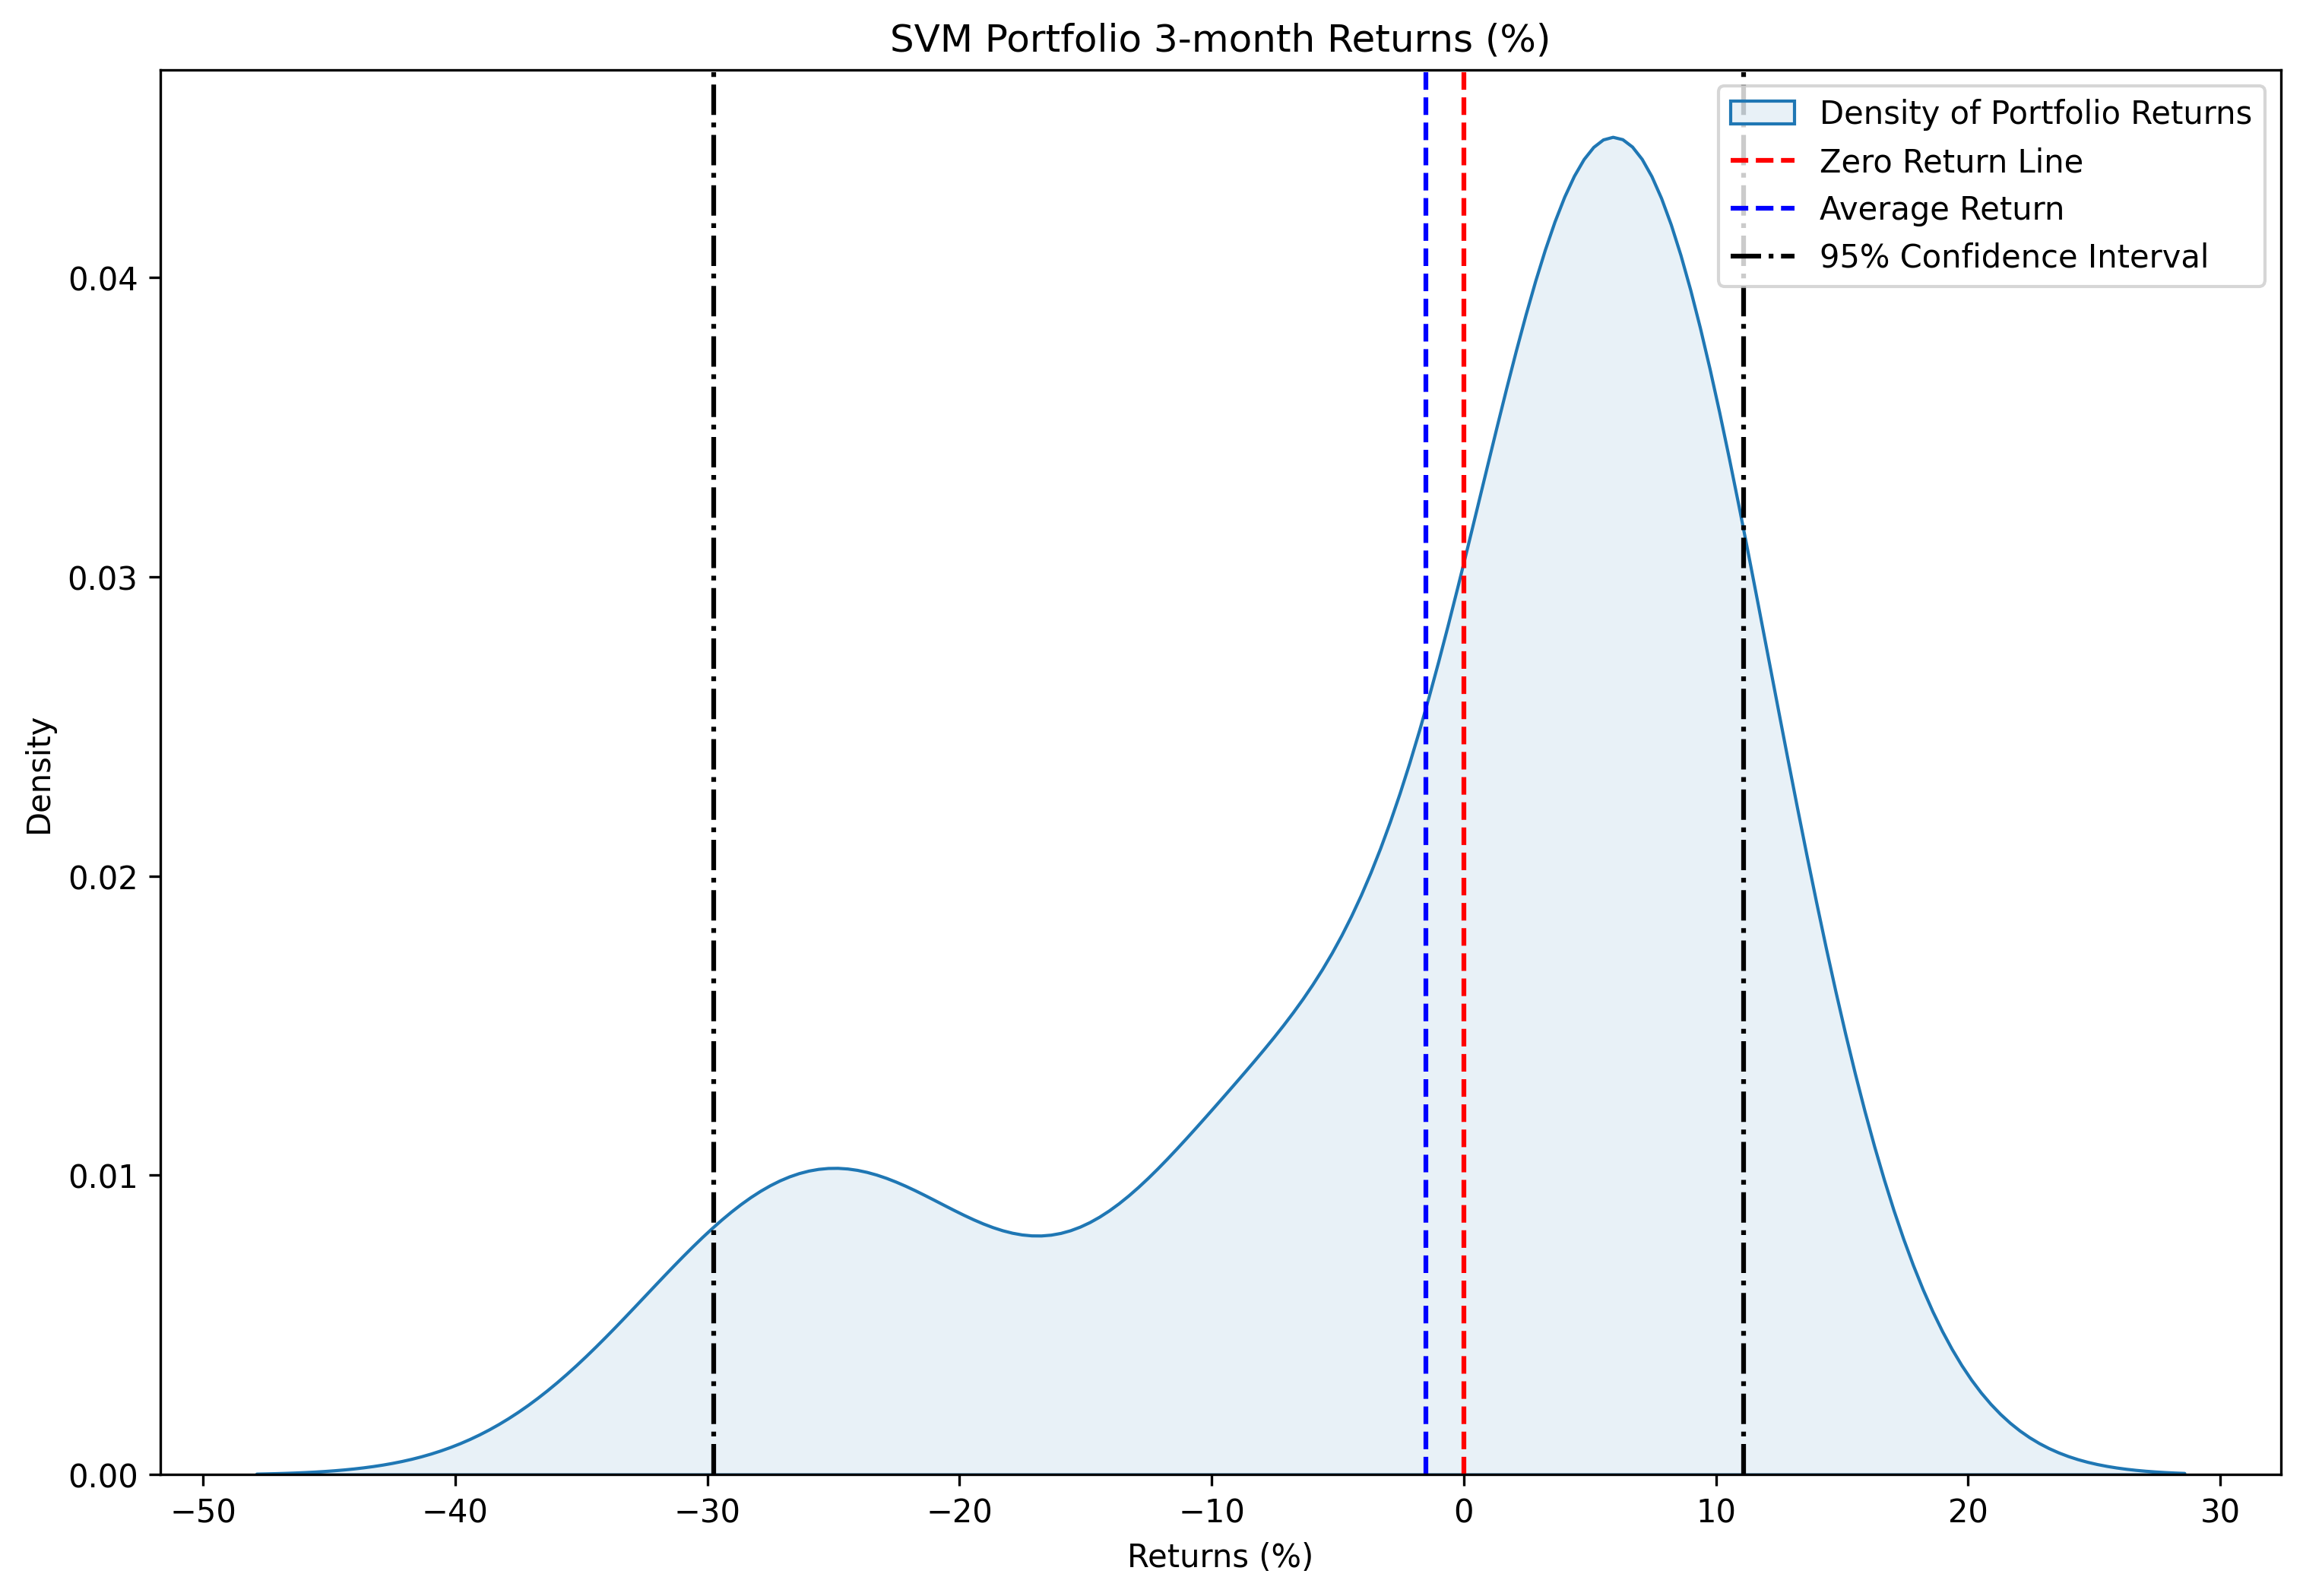

In [66]:
# make density plot of the returns
plt.figure(figsize=(12,8), facecolor='white', dpi=300)
sns.kdeplot(data=returns_df, x='SVM Portfolio 3-month Returns (%)', fill=True, alpha=0.1)
# make 0 vertical line
plt.axvline(x=0, color='r', linestyle='--')
# make average return vertical line
plt.axvline(x=returns_df['SVM Portfolio 3-month Returns (%)'].mean(), color='b', linestyle='--')
# include confindence interval vertical lines
lower_bound = np.quantile(returns_df['SVM Portfolio 3-month Returns (%)'], 0.025)
upper_bound = np.quantile(returns_df['SVM Portfolio 3-month Returns (%)'], 0.975)
plt.axvline(x=lower_bound, color='black', linestyle='dashdot')
plt.axvline(x=upper_bound, color='black', linestyle='dashdot')
plt.legend(['Density of Portfolio Returns','Zero Return Line', 'Average Return', '95% Confidence Interval'], loc='upper right')
plt.title('SVM Portfolio 3-month Returns (%)')
plt.ylabel('Density')
plt.xlabel('Returns (%)')
plt.show()


In [118]:
# average return
print('Average return:', round(returns_df.mean()[0],2))

Average return: 0.07


In [290]:
# show the 10 days with the most return
returns_df.sort_values(by=['SVM Portfolio 3-month Returns (%)'], ascending=False).head(10)


,SVM Portfolio 3-month Returns (%)
2019-11-27,12.4
2019-10-10,11.4
2019-10-21,10.6
2019-10-18,10.4
2019-10-29,9.9
2019-10-25,9.7
2019-11-25,9.6
2019-10-11,9.6
2019-11-22,9.4
2019-10-08,9.4


SP500 return in the same period

In [267]:
import yfinance as yf
from pandas_datareader import data as pdr
# This line is needed to fix a problem with pandas_datareader
yf.pdr_override()

start_date = '2019-10-01'
end_date = '2020-04-02'
# 
# Get data from Yahoo Finance
sp500 = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)
# we are only interested in the open price
sp500 = sp500['Open']
# Transform it into a dataframe
sp500_returns = pd.DataFrame(sp500)
# Make 'S&P 500 Index Price' the column header
sp500_returns = sp500_returns.rename(columns={'Open': 'S&P 500 Index Price'})
# Calculate the 3 month return for each day
sp500_returns['S&P 500 - 3 Month Return (%)'] = sp500_returns['S&P 500 Index Price'].pct_change(periods=63).shift(-63)
# calculating all 3-month return values by 100 to obtain percent
sp500_returns['S&P 500 - 3 Month Return (%)'] = sp500_returns['S&P 500 - 3 Month Return (%)'] * 100
sp500_returns.round(2)
# remove the S&P 500 Index Price column
sp500_returns = sp500_returns.drop(columns=['S&P 500 Index Price'])
# removing all rows with NaN values (The last 62 days, since they don't have data for 3 months into the future)
sp500_returns = sp500_returns.dropna()
# remove the last 20 days of the test set
#sp500_returns = sp500_returns.iloc[:-21]
sp500_returns

[*********************100%***********************]  1 of 1 completed


,S&P 500 - 3 Month Return (%)
Date,
2019-10-01,7.758514
2019-10-02,10.937229
2019-10-03,11.817516
2019-10-04,10.244435
2019-10-07,10.108929
...,...
2019-12-24,-22.451438
2019-12-26,-20.802239
2019-12-27,-21.194988


In [284]:
# add the returns of random monkey model as a new column
random_monkey_returns = pd.read_csv('random_monkey_portfolio_returns.csv', index_col=0)

In [285]:
# make random monkey index as datetime
random_monkey_returns.index = pd.to_datetime(random_monkey_returns.index)


In [286]:
# Combine the returns of the portfolio and the S&P 500
combined_returns = pd.concat([returns_df, sp500_returns], axis='columns', join='inner')

#combined_returns['Random Monkey Portfolio 62-day Returns (%)'] = random_monkey_returns['Random Monkey - 3 Month Return (%)']
# make a column that shows the difference between the portfolio returns and the S&P 500 returns
#combined_returns['Difference (%)'] = combined_returns['Portfolio 62-day Returns (%)'] - combined_returns['S&P 500 - 3 Month Return (%)']
combined_returns.round(1)

,SVM Portfolio 3-month Returns (%),S&P 500 - 3 Month Return (%)
2019-10-01,8.7,7.8
2019-10-02,7.4,10.9
2019-10-03,8.2,11.8
2019-10-04,8.8,10.2
2019-10-07,7.8,10.1
...,...,...
2019-12-24,-13.0,-22.5
2019-12-26,-20.7,-20.8
2019-12-27,-18.1,-21.2
2019-12-30,-17.8,-19.3


In [495]:
#random_monkey_returns = random_monkey_returns.iloc[:-21]

In [287]:
# add a new column that shows the Random Monkey returns
combined_returns['Random Monkey 63-day Returns (%)'] = random_monkey_returns['Random Monkey - 3 Month Return (%)'].copy()
round(combined_returns,1)

,SVM Portfolio 3-month Returns (%),S&P 500 - 3 Month Return (%),Random Monkey 63-day Returns (%)
2019-10-01,8.7,7.8,10.7
2019-10-02,7.4,10.9,14.1
2019-10-03,8.2,11.8,10.8
2019-10-04,8.8,10.2,16.6
2019-10-07,7.8,10.1,5.7
...,...,...,...
2019-12-24,-13.0,-22.5,-33.9
2019-12-26,-20.7,-20.8,-27.7
2019-12-27,-18.1,-21.2,-30.7
2019-12-30,-17.8,-19.3,-17.8


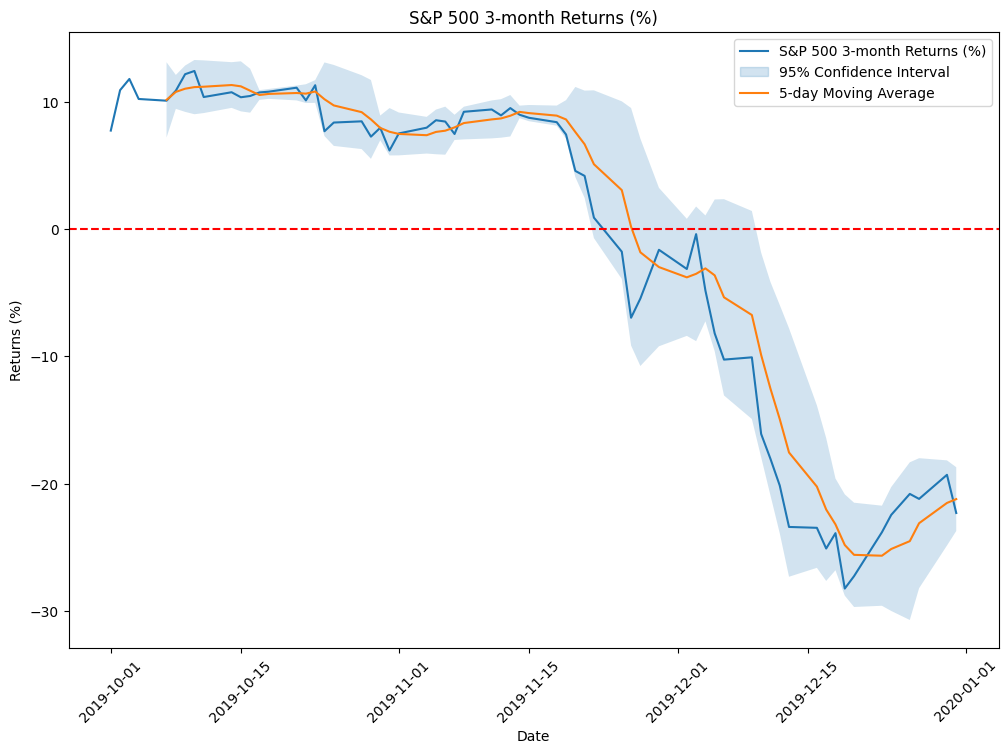

In [395]:
import seaborn as sns
import matplotlib.pyplot as plt
# make the plot for the S&P 500 returns
# moving average
combined_returns['S&P 500 - 3 Month Return (%) - Moving Average'] = combined_returns['S&P 500 - 3 Month Return (%)'].rolling(window=5).mean()
# moving standard deviation
combined_returns['S&P 500 - 3 Month Return (%) - Moving Standard Deviation'] = combined_returns['S&P 500 - 3 Month Return (%)'].rolling(window=5).std()
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.lineplot(data=combined_returns, x=combined_returns.index, y='S&P 500 - 3 Month Return (%)')
# include moving average line
sns.lineplot(data=combined_returns, x=combined_returns.index, y='S&P 500 - 3 Month Return (%) - Moving Average')
# include the 0 horizontal line
plt.axhline(y=0, color='r', linestyle='--')
# include shaded area for the moving average confidence interval
plt.fill_between(combined_returns.index, combined_returns['S&P 500 - 3 Month Return (%) - Moving Average'] - 1.96 * combined_returns['S&P 500 - 3 Month Return (%) - Moving Standard Deviation'], combined_returns['S&P 500 - 3 Month Return (%) - Moving Average'] + 1.96 * combined_returns['S&P 500 - 3 Month Return (%) - Moving Standard Deviation'], alpha=0.2)
plt.title('S&P 500 3-month Returns (%)')
plt.ylabel('Returns (%)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(['S&P 500 3-month Returns (%)', '95% Confidence Interval','5-day Moving Average'], loc='upper right')
plt.show()






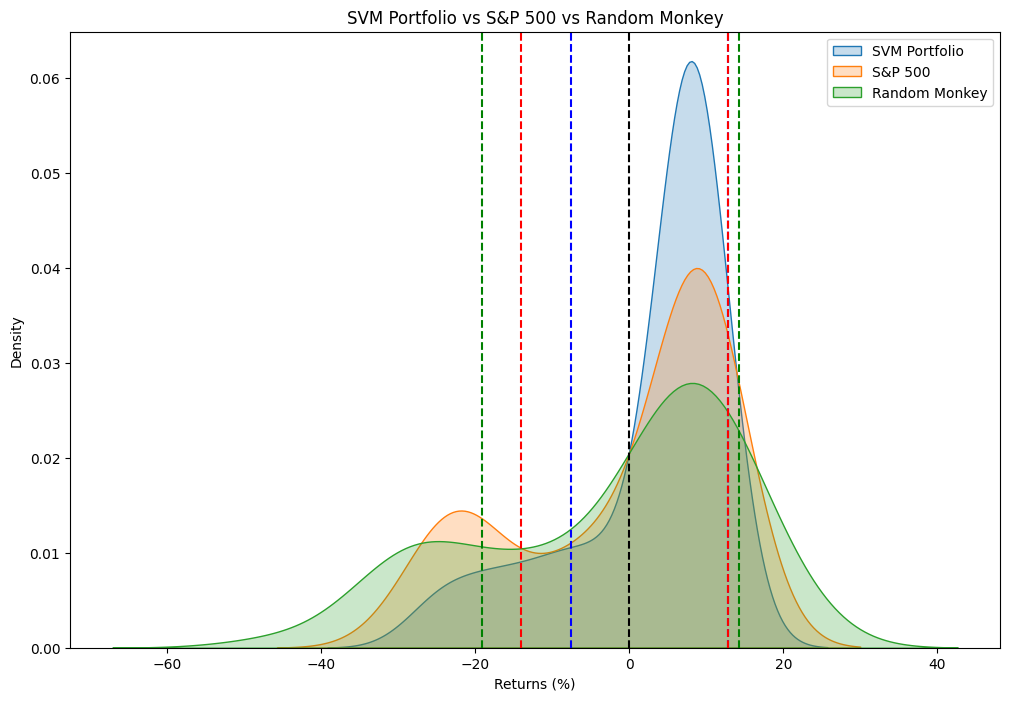

In [354]:
# make density plot for the three returns
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.kdeplot(data=combined_returns, x='SVM Portfolio 3-month Returns (%)', fill=True, label='SVM Portfolio')
sns.kdeplot(data=combined_returns, x='S&P 500 - 3 Month Return (%)', fill=True, label='S&P 500')
sns.kdeplot(data=combined_returns, x='Random Monkey 63-day Returns (%)', fill=True, label='Random Monkey')
# confidence interval for the portfolios
plt.axvline(x=combined_returns['SVM Portfolio 3-month Returns (%)'].mean() + combined_returns['SVM Portfolio 3-month Returns (%)'].std(), color='b', linestyle='--')
plt.axvline(x=combined_returns['SVM Portfolio 3-month Returns (%)'].mean() - combined_returns['SVM Portfolio 3-month Returns (%)'].std(), color='b', linestyle='--')
# confidence interval for the S&P 500
plt.axvline(x=combined_returns['S&P 500 - 3 Month Return (%)'].mean() + combined_returns['S&P 500 - 3 Month Return (%)'].std(), color='r', linestyle='--')
plt.axvline(x=combined_returns['S&P 500 - 3 Month Return (%)'].mean() - combined_returns['S&P 500 - 3 Month Return (%)'].std(), color='r', linestyle='--')
# confidence interval for the Random Monkey
plt.axvline(x=combined_returns['Random Monkey 63-day Returns (%)'].mean() + combined_returns['Random Monkey 63-day Returns (%)'].std(), color='g', linestyle='--')
plt.axvline(x=combined_returns['Random Monkey 63-day Returns (%)'].mean() - combined_returns['Random Monkey 63-day Returns (%)'].std(), color='g', linestyle='--')
plt.title('SVM Portfolio vs S&P 500 vs Random Monkey')
# make 0 vertical line
plt.axvline(x=0, color='black', linestyle='--')
# make legend
plt.legend()
plt.ylabel('Density')
plt.xlabel('Returns (%)')
plt.show()

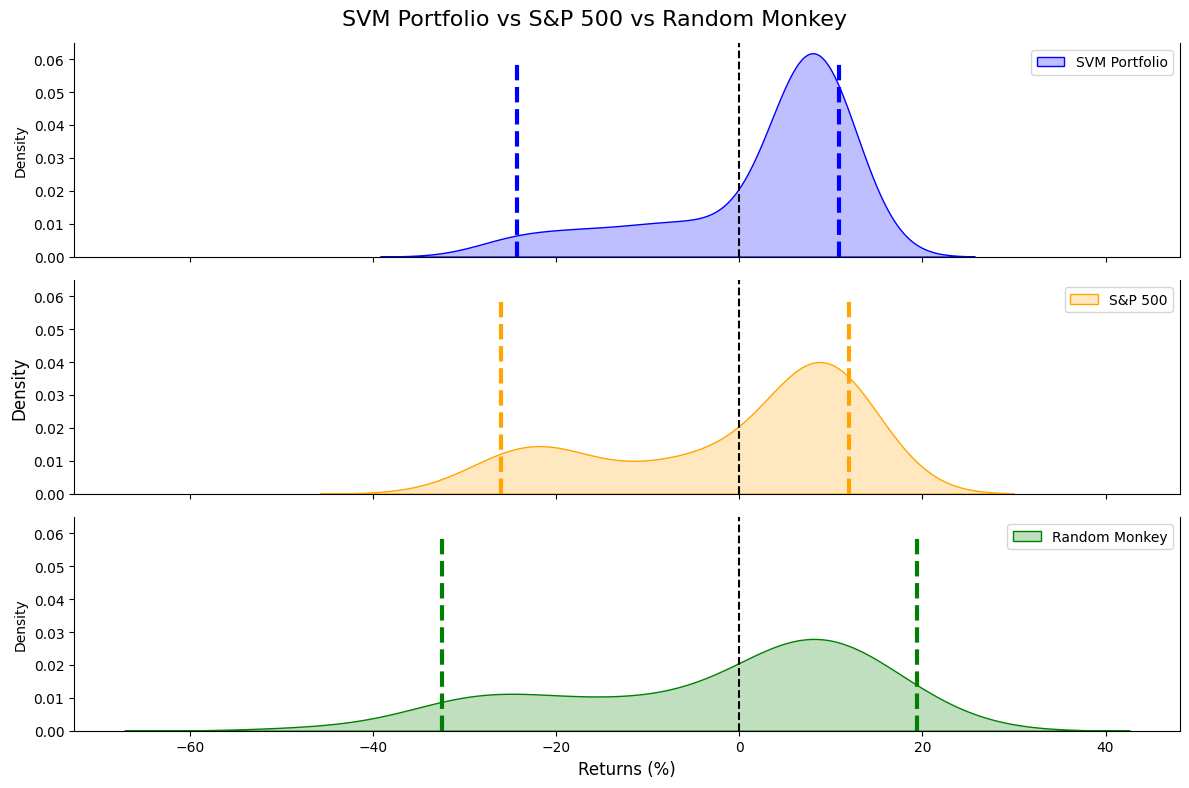

In [377]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True, dpi=100)

# Define labels and columns
labels = ['SVM Portfolio', 'S&P 500', 'Random Monkey']
columns = ['SVM Portfolio 3-month Returns (%)', 'S&P 500 - 3 Month Return (%)', 'Random Monkey 63-day Returns (%)']
colors = ['blue', 'orange', 'green']

# Iterate over labels, columns and axes simultaneously
for label, column, color, ax in zip(labels, columns, colors, axes):
    # Make density plot
    sns.kdeplot(data=combined_returns, x=column, fill=True, ax=ax, label=label, color=color)

    # Draw vertical lines for the confidence intervals
    # confidence interval quantiles
    ci_lower = np.quantile(combined_returns[column], 0.025)
    ci_upper = np.quantile(combined_returns[column], 0.975)
    ax.plot([ci_lower, ci_lower], [0, 0.06], color=color, linestyle='--', linewidth=3)
    ax.plot([ci_upper, ci_upper], [0, 0.06], color=color, linestyle='--', linewidth=3)
    
    # Add zero line
    ax.axvline(x=0, color='black', linestyle='--')
    # remove box around plot
    ax.spines['top'].set_visible(False)
    # Set title and legend
    #ax.set_title(label)
    ax.legend()
# make title for entire plot
fig.suptitle('SVM Portfolio vs S&P 500 vs Random Monkey', fontsize=16)
# Set common labels
axes[1].set_ylabel('Density', fontsize=12)
axes[2].set_xlabel('Returns (%)', fontsize=12)

plt.tight_layout()
plt.show()




In [273]:
# average return of each column
average_return = combined_returns.mean()
average_return


SVM Portfolio 3-month Returns (%)    2.567187
S&P 500 - 3 Month Return (%)        -0.607695
Random Monkey 63-day Returns (%)    -1.370312
dtype: float64

In [274]:
# standard deviation of each column
standard_deviation = combined_returns.std()
standard_deviation

SVM Portfolio 3-month Returns (%)    10.193245
S&P 500 - 3 Month Return (%)         13.419681
Random Monkey 63-day Returns (%)     15.791083
dtype: float64

In [373]:
# 95% confidence interval of each column
confidence_interval = combined_returns.quantile([0.025, 0.975])
confidence_interval

,SVM Portfolio 3-month Returns (%),S&P 500 - 3 Month Return (%),Random Monkey 63-day Returns (%)
0.025,-24.225,-26.018516,-32.4625
0.975,10.940,11.976797,19.3950


In [275]:
# calculate median of each column
median = combined_returns.median()
median

SVM Portfolio 3-month Returns (%)    7.400000
S&P 500 - 3 Month Return (%)         7.513485
Random Monkey 63-day Returns (%)     3.850000
dtype: float64

In [323]:
# max and min return of SP500 and their dates
max_return = combined_returns['S&P 500 - 3 Month Return (%)'].max()
max_return_date = combined_returns['S&P 500 - 3 Month Return (%)'].idxmax()
min_return = combined_returns['S&P 500 - 3 Month Return (%)'].min()
min_return_date = combined_returns['S&P 500 - 3 Month Return (%)'].idxmin()
print('Max return:', round(max_return,2), 'on', max_return_date)
print('Min return:', round(min_return,2), 'on', min_return_date)

Max return: 12.45 on 2019-10-10
Min return: -28.24 on 2019-12-19


In [324]:
import numpy as np
from scipy.stats import friedmanchisquare

# let's assume these are your 3-month returns for each model
svm_returns = combined_returns['SVM Portfolio 3-month Returns (%)']
sp500_returns = combined_returns['S&P 500 - 3 Month Return (%)']
random_monkey_returns = combined_returns['Random Monkey 63-day Returns (%)']
# apply Friedman test
stat, p = friedmanchisquare(svm_returns, sp500_returns, random_monkey_returns)

print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')



Statistics=8.620, p=0.013
Different distributions (reject H0)


In [325]:
from scipy.stats import wilcoxon

# Pairwise comparison for SVM vs S&P 500
stat, p = wilcoxon(svm_returns, sp500_returns)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print('SVM vs SP500: Same distribution (fail to reject H0)')
else:
    print('SVM vs SP500: Different distribution (reject H0)')

# Pairwise comparison for SVM vs Random Monkey
stat, p = wilcoxon(svm_returns, random_monkey_returns)
print('\nStatistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print('SVM vs Random Monkey: Same distribution (fail to reject H0)')
else:
    print('SVM vs Random Monkey: Different distribution (reject H0)')

# Pairwise comparison for S&P 500 vs Random Monkey
stat, p = wilcoxon(sp500_returns, random_monkey_returns)
print('\nStatistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print('SP500 vs Random Monkey: Same distribution (fail to reject H0)')
else:
    print('SP500 vs Random Monkey: Different distribution (reject H0)')


Statistics=739.000, p=0.044
SVM vs SP500: Different distribution (reject H0)

Statistics=507.500, p=0.001
SVM vs Random Monkey: Different distribution (reject H0)

Statistics=700.000, p=0.023
SP500 vs Random Monkey: Different distribution (reject H0)


In [333]:
# The sign test, which does not assume that the distributions are symmetrical
from scipy import stats

# Calculate differences for each pair of portfolios
diff_svm_sp500 = svm_returns - sp500_returns
diff_svm_random = svm_returns - random_monkey_returns
diff_sp500_random = sp500_returns - random_monkey_returns


# Perform Sign test
p_value_svm_sp500 = stats.binom_test((diff_svm_sp500 > 0).sum(), n=len(diff_svm_sp500), alternative='two-sided')
p_value_svm_random = stats.binom_test((diff_svm_random > 0).sum(), n=len(diff_svm_random), alternative='two-sided')
p_value_sp500_random = stats.binom_test((diff_sp500_random > 0).sum(), n=len(diff_sp500_random), alternative='two-sided')

print(f"p-value for the difference between SVM portfolio and SP500: {p_value_svm_sp500}")
print(f"p-value for the difference between SVM portfolio and Random portfolio: {p_value_svm_random}")
print(f"p-value for the difference between SP500 and Random portfolio: {p_value_sp500_random}")



p-value for the difference between SVM portfolio and SP500: 0.7079807541347641
p-value for the difference between SVM portfolio and Random portfolio: 0.008146902228698568
p-value for the difference between SP500 and Random portfolio: 0.10342187831608088


C:\Users\nicol\AppData\Local\Temp\ipykernel_37208\2937811727.py:11: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value_svm_sp500 = stats.binom_test((diff_svm_sp500 > 0).sum(), n=len(diff_svm_sp500), alternative='two-sided')
C:\Users\nicol\AppData\Local\Temp\ipykernel_37208\2937811727.py:12: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value_svm_random = stats.binom_test((diff_svm_random > 0).sum(), n=len(diff_svm_random), alternative='two-sided')
C:\Users\nicol\AppData\Local\Temp\ipykernel_37208\2937811727.py:13: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value_sp500_random = stats.binom_test((diff_sp500_random > 0).sum(), n=len(diff_sp500_random), alternative='two-sided')


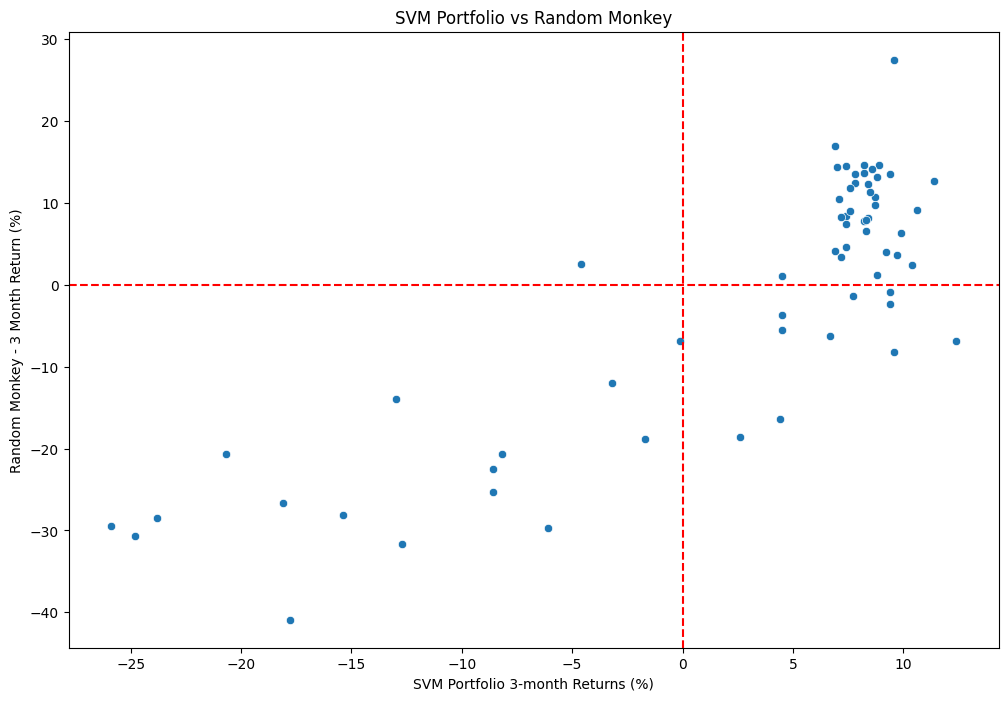

In [278]:
# make risk vs return plot
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.scatterplot(data=combined_returns, x='SVM Portfolio 3-month Returns (%)', y='Random Monkey 63-day Returns (%)')
# make 0 horizontal line
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.title('SVM Portfolio vs Random Monkey')
plt.ylabel('Random Monkey - 3 Month Return (%)')
plt.xlabel('SVM Portfolio 3-month Returns (%)')
plt.show()

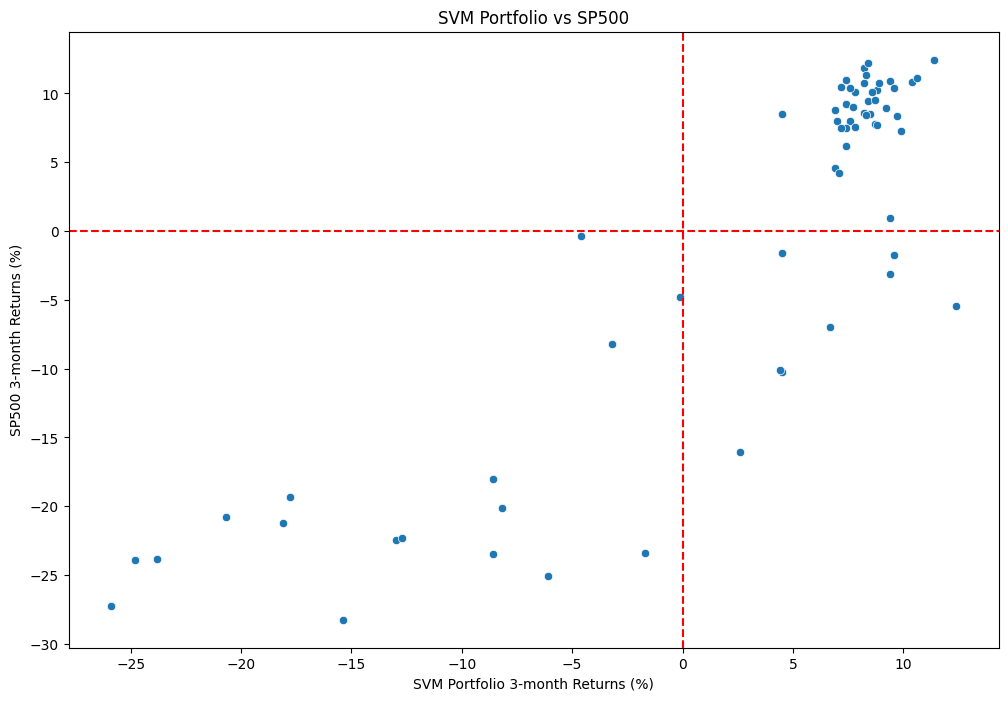

In [279]:
# make risk vs return plot
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.scatterplot(data=combined_returns, x='SVM Portfolio 3-month Returns (%)', y='S&P 500 - 3 Month Return (%)')
# make 0 horizontal line
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.title('SVM Portfolio vs SP500')
plt.ylabel('SP500 3-month Returns (%)')
plt.xlabel('SVM Portfolio 3-month Returns (%)')
plt.show()